In [1]:
%load_ext autoreload

In [2]:
from argparse import ArgumentParser
from pathlib import Path
import typing as tp

import torch

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from ml_collections import ConfigDict

In [3]:
%autoreload 2
from train_with_stylegan.trainer import DIffGANTrainer
from train_with_stylegan.utils import configure_unet_model_from_pretrained
from train_with_stylegan.train import load_params, configure_checkpoint_path

In [4]:
device = torch.device(f"{args.device}") if torch.cuda.is_available else torch.device("cpu")
teacher = configure_unet_model_from_pretrained(args.teacher)
student = configure_unet_model_from_pretrained(args.teacher)

teacher.to(device)
student.to(device)

teacher.eval()
student.train()

log_dir, last_ckpt = configure_checkpoint_path(args)

NameError: name 'args' is not defined

### Config from diffusers

In [116]:
from diffusers import DDPMPipeline

In [117]:
ddpm_pipeline = DDPMPipeline.from_pretrained("google/ddpm-cifar10-32")

In [118]:
ddpm_pipeline.scheduler

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.18.2",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "sample_max_value": 1.0,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "variance_type": "fixed_large"
}

### Sample Images

In [5]:
args = dict(
    name="student",
    teacher="google/ddpm-cifar10-32",
    params=Path("./train_with_stylegan/params/boot.yaml"),
    device="cpu",
    project="boot",
    dir=Path("boot-ckpt")
)
args = ConfigDict(args)
params = load_params(args)

In [11]:
dict(params.unet)

{'attention_resolutions': [16, 8],
 'channel_mult': [1, 1, 2, 2, 4, 4],
 'conv_resample': True,
 'dims': 2,
 'dropout': 0,
 'in_channels': 3,
 'model_channels': 128,
 'num_classes': None,
 'num_heads': 1,
 'num_heads_upsample': -1,
 'num_res_blocks': 2,
 'out_channels': 3,
 'return_hidden': True,
 'use_checkpoint': False,
 'use_scale_shift_norm': False}

In [363]:
# Run if you want discrete sampler
params.training.continuous = False
params.training.beta_min = 0.0001
params.training.beta_max = 0.02

In [370]:
trainer = DIffGANTrainer(
    teacher=teacher,
    student=student,
    params=params,
    device=device,
    log_dir=log_dir,
)

print(params.training.continuous)
print(params.training.beta_max)
print(params.training.beta_min)

True
20.0
0.1


In [371]:
images = trainer.sample_with_teacher(1)

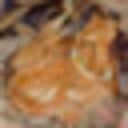

In [372]:
idx = 0
Image.fromarray(np.uint8(images.permute(0, 2, 3, 1).numpy()[idx] * 255)).resize((128,128), Image.BICUBIC)

### Experiments with functions

In [121]:
T = 1000
betas = np.linspace(0.0001, 0.02, T, dtype=np.float64)
self_alphas_cumprod = np.cumprod(1 - betas)

t = 34

alpha_prod_t = self_alphas_cumprod[t]
beta_prod_t = 1 - alpha_prod_t

sigma_fn(torch.tensor(t / T)), beta_prod_t**0.5

(tensor(0.1216), 0.12344683312338371)

In [122]:
alpha_prod_t ** 0.5, alpha_fn(torch.tensor(t / T))

(0.9923511875298016, tensor(0.9926))

In [117]:
T = 1000
betas = np.linspace(0.0001, 0.02, T, dtype=np.float64)
self_alphas_cumprod = np.cumprod(1 - betas)


x_0_coeff = []
x_t_coeff = []
x_0_coeff_c = []
x_t_coeff_c = []
prev_t = -1
for t in range(T):
    alpha_prod_t = self_alphas_cumprod[t]
    alpha_prod_t_prev = self_alphas_cumprod[prev_t] if prev_t >= 0 else 1
    beta_prod_t = 1 - alpha_prod_t
    beta_prod_t_prev = 1 - alpha_prod_t_prev
    current_alpha_t = alpha_prod_t / alpha_prod_t_prev
    current_beta_t = 1 - current_alpha_t
    
    pred_original_sample_coeff = (alpha_prod_t_prev ** (0.5) * current_beta_t) / beta_prod_t
    current_sample_coeff = current_alpha_t ** (0.5) * beta_prod_t_prev / beta_prod_t
    x_0_coeff.append(pred_original_sample_coeff)
    x_t_coeff.append(current_sample_coeff)
    prev_t = t
    
    t = torch.ones(1) * t
    t_tilda = torch.maximum(t / 1000, torch.tensor(1e-6))
    t_prev_tilda = torch.maximum((t - 1) / 1000, torch.tensor(1e-6))

    alpha_t = alpha_fn(t_tilda).numpy()[0]
    alpha_prev = alpha_fn(t_prev_tilda).numpy()[0]
    if alpha_t == alpha_prev:
        alpha_prev = 1

    sigma_t = sigma_fn(t_tilda).numpy()[0]
    sigma_prev = sigma_fn(t_prev_tilda).numpy()[0]
    if sigma_t == sigma_prev:
        sigma_prev = 0
    
    pred_original_sample_coeff = (alpha_prev / sigma_t ** 2) * (1 - (alpha_t / alpha_prev) ** 2)
    current_sample_coeff = np.sqrt(alpha_t / alpha_prev) * ((sigma_prev / sigma_t) ** 2)
    x_0_coeff_c.append(pred_original_sample_coeff)
    x_t_coeff_c.append(current_sample_coeff)
    
# x_0_coeff_c =  np.array(x_0_coeff_c).flatten()
# x_0_coeff_c[0] = 1
# x_t_coeff_c =  np.array(x_t_coeff_c).flatten()
# x_t_coeff_c[0] = 0

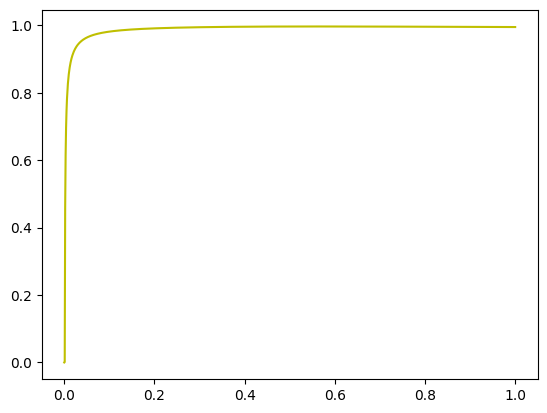

In [119]:
t = np.linspace(0, 1, T)
# plt.plot(t, np.array(x_0_coeff), c="r")
# plt.plot(t, x_t_coeff, c="b")
# plt.plot(t, np.array(x_0_coeff_c), c="g")
plt.plot(t, x_t_coeff_c, c="y")
plt.show()

In [40]:
alpha_fn = trainer._diffusion_scheduler._alpha_fn
sigma_fn = trainer._diffusion_scheduler._sigma_fn

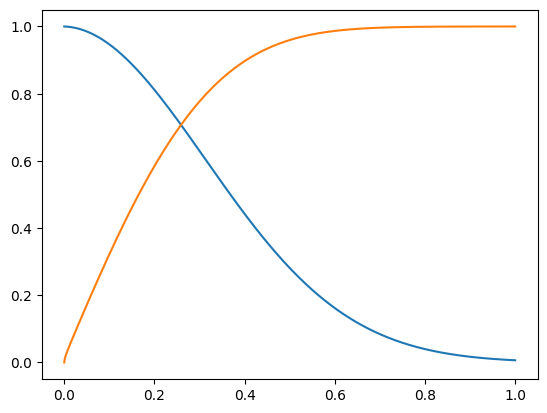

In [41]:
t = np.linspace(0, 1, 1000)
plt.plot(t, alpha_fn(torch.from_numpy(t)).numpy())
plt.plot(t, sigma_fn(torch.from_numpy(t)).numpy())
plt.show()

### Test student models

In [49]:
from diffusers import UNet2DModel
import torch

import numpy as np
from PIL import Image

import os

In [150]:
os.listdir("./wandb-checkpoints")

['boot-lpips',
 'boot',
 'boot-gan-heun-discr_every_step',
 'boot-lr_0.001',
 't-couninious',
 'boot-v2.0',
 'boot-fixed',
 'boot-gan-heun',
 'boot-reprod',
 'boot-lr_0.0001',
 'boot-fixed-heun',
 'boot-v2',
 'boot-gan',
 'boot-baseline-v.2',
 'boot-gan-v.2',
 'wandb',
 'boot-ddp']

In [186]:
model = UNet2DModel.from_pretrained("google/ddpm-cifar10-32")
model.to("cuda:0")
ckpt = torch.load("./wandb-checkpoints/boot-v2/ckpt-step-35000.pt", map_location="cuda:0")
# ckpt = torch.load("./wandb-checkpoints/boot-lr_0.0001/ckpt-step-190000.pt", map_location="cuda:0")
# model.load_state_dict(ckpt["student"])

In [187]:
model_state_dict = model.state_dict()
new_state_dict = model_state_dict.copy()

param_keys = model_state_dict.keys()
for name in param_keys:
    new_state_dict[name] = ckpt['student'][f'module.{name}']
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [188]:
n_samples = 30

z = torch.randn(n_samples, 3, 32, 32).to("cuda:0")
t = torch.zeros(n_samples).to("cuda:0")

with torch.no_grad():
    model_out = model(z, t).sample.cpu()

In [189]:
with torch.no_grad():
    model_out = model(z, t).sample.cpu()
model_out.shape

torch.Size([30, 3, 32, 32])

In [190]:
 b_min = torch.min(torch.min(torch.min(model_out, -1)[0], -1)[0], -1)[0].view(-1, 1, 1, 1)
 b_max = torch.max(torch.max(torch.max(model_out, -1)[0], -1)[0], -1)[0].view(-1, 1, 1, 1)
print(b_min.squeeze())
print(b_max.squeeze())

tensor([-1.3209, -1.2428, -1.3212, -1.1669, -1.1214, -1.1589, -1.5280, -1.1272,
        -1.3974, -1.2388, -1.2232, -1.2447, -1.2987, -1.3259, -1.3300, -1.4850,
        -1.3203, -1.1663, -1.3031, -1.3249, -1.2924, -1.2196, -1.1853, -1.3041,
        -1.1804, -1.3817, -1.1029, -1.1635, -1.3059, -1.1166])
tensor([ 1.1741,  1.1877,  1.3820,  1.2391,  1.0311,  0.8757,  1.3844, -1.0003,
         1.2034,  1.1532,  1.2680,  1.1107,  1.2240,  1.2553,  1.3058,  1.2573,
         1.3963,  1.1132,  1.1311,  1.2347,  1.1489,  1.2033,  1.1423,  1.1669,
         1.1404,  1.1914,  1.0891,  1.1423,  1.3005,  0.8862])


In [191]:
images = (model_out.permute(0, 2, 3, 1).detach().cpu() - b_min) / (b_max - b_min)
images = (images.numpy() * 255).astype(np.uint8)

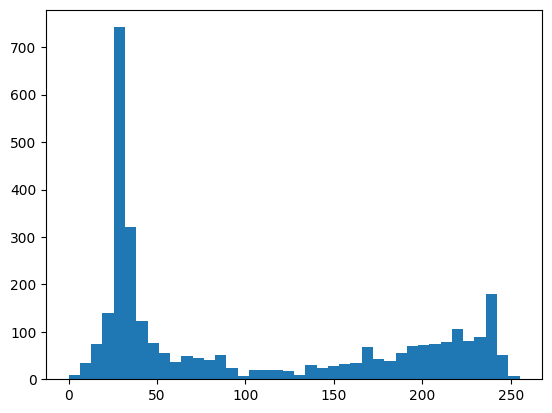

In [213]:
# plt.hist(model_out[0].detach().cpu().numpy().flatten(), bins=40)
plt.hist(images[8].flatten(), bins=40)
plt.show()

In [259]:
def tensor_min(x, dims, keepdims: bool = False):
    for dim in dims:
        x = torch.min(x, dim, keepdim=True)[0]
    return x if keepdims else x.squeeze()

def tensor_max(x, dims, keepdims: bool = False):
    for dim in dims:
        x = torch.max(x, dim, keepdim=True)[0]
    return x if keepdims else x.squeeze()

In [266]:
def interpolate(image: np.ndarray):
    return np.asarray(Image.fromarray(image).resize((128,128), Image.BICUBIC))

def post_process(images):
    b_min = tensor_min(images, dims=(1, 2, 3), keepdims=True)
    b_max = tensor_max(images, dims=[1, 2, 3), keepdims=True)
    images = (model_out.permute(0, 2, 3, 1).detach().cpu() - b_min) / (b_max - b_min)
    return (images.numpy() * 255).astype(np.uint8)

def plot_images(images, n_rows: int = 5, n_cols: int = 10):
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(18, 8))
    count = 0
    for row in range(n_rows):
        for col in range(n_cols):
            ax[row, col].imshow(interpolate(images[count]))
            ax[row, col].axis("off")
            count += 1
    plt.show()

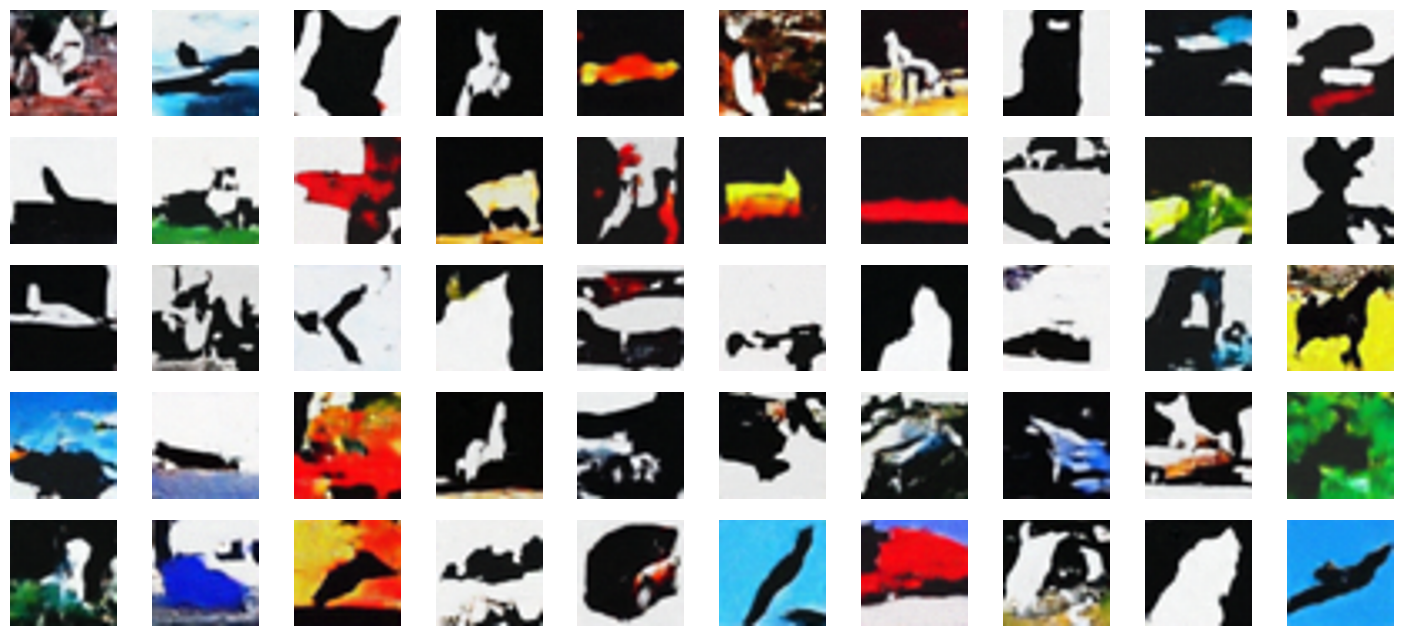

In [267]:
n_samples = 50

z = torch.randn(n_samples, 3, 32, 32).to("cuda:0")
t = torch.zeros(n_samples).to("cuda:0")

with torch.no_grad():
    model_out = model(z, t).sample.cpu()

images = post_process(model_out)
plot_images(images)